# Explore the reference network


- [Crossref](https://www.crossref.org/) provides an API to get the references of a publication ([rest-api-doc](https://github.com/CrossRef/rest-api-doc)).


- A first idea is to go down the references for a fixed number of steps (for example 3), then keep only the articles which have been visited more than N times (for examples 3 times), and draw the upward graph starting from these articles. 
- Second idea: to look a the top cited articles in the creates graph

## To do:
- resolve idnetical label
- knowledge reduction again: weighted edge?

- stats:  n ref vs n citation, review vs foundational

- disconnected component for the 1st generation references: coloring 

- use 'store' from scopus manual export + [query ref resolver](https://www.crossref.org/labs/resolving-citations-we-dont-need-no-stinkin-parser/)


### Knowledge reduction
- ne pas afficher les references, si au moins une des references l'utilise
- supprime un lien si un chemin plus long existe




In [18]:
%load_ext autoreload
%autoreload 2

import crossrefexp as exp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Create the interface to acces metadata
store = exp.MetaDataStore()

169 metadata loaded from `data/cachefile.pickle`


In [20]:
store.reset()

Delete `data/cachefile.pickle` 0.83 Mo, 
 Are you sure? [type yes] 
canceled


In [56]:
metadata = store.get( '10.1016/j.commatsci.2018.04.065' )
metadata.printinfo()

(2018) Plastic flow and dislocation strengthening in a dislocation density based f...
   M. Sudmanns et al. - Computational Materials Science
   http://dx.doi.org/10.1016/j.commatsci.2018.04.065


In [63]:
metadata

{'DOI': '10.1016/j.commatsci.2018.04.065',
 'ISSN': ['0927-0256'],
 'URL': 'http://dx.doi.org/10.1016/j.commatsci.2018.04.065',
 'alternative-id': ['S0927025618303069'],
 'assertion': [{'label': 'This article is maintained by',
   'name': 'publisher',
   'value': 'Elsevier'},
  {'label': 'Article Title',
   'name': 'articletitle',
   'value': 'Plastic flow and dislocation strengthening in a dislocation density based formulation of plasticity'},
  {'label': 'Journal Title',
   'name': 'journaltitle',
   'value': 'Computational Materials Science'},
  {'label': 'CrossRef DOI link to publisher maintained version',
   'name': 'articlelink',
   'value': 'http://dx.doi.org/10.1016/j.commatsci.2018.04.065'},
  {'label': 'Content Type', 'name': 'content_type', 'value': 'article'},
  {'label': 'Copyright',
   'name': 'copyright',
   'value': '© 2018 Elsevier B.V. All rights reserved.'}],
 'author': [{'affiliation': [],
   'family': 'Sudmanns',
   'given': 'M.',
   'sequence': 'first'},
  {'affil

In [50]:
# Create a reference graph atarting at the given DOI
gr = exp.ReferenceGraph( '10.1016/j.actamat.2014.03.012' )
gr

{'10.1016/j.actamat.2014.03.012': {'citedBy': [], 'gen': 0}}

In [54]:
# Expand the graph for N-generation
store.grow( gr, N=1 )

- done -1          


In [55]:
len( gr ), len(store)

(1, 371)

In [32]:
from graphviz import Digraph

In [48]:
# Build the upward graph starting from the top-N cited articles
nodes, links = gr.upward_graph(5)

def getlabel(doi):
    return store.get(doi).label()

color_list = ['red', 'gold1', 'cyan3', 'darkorchid2', 'chartreuse2']
def getcolor(doi):
    return color_list[ gr[doi]['gen'] ]

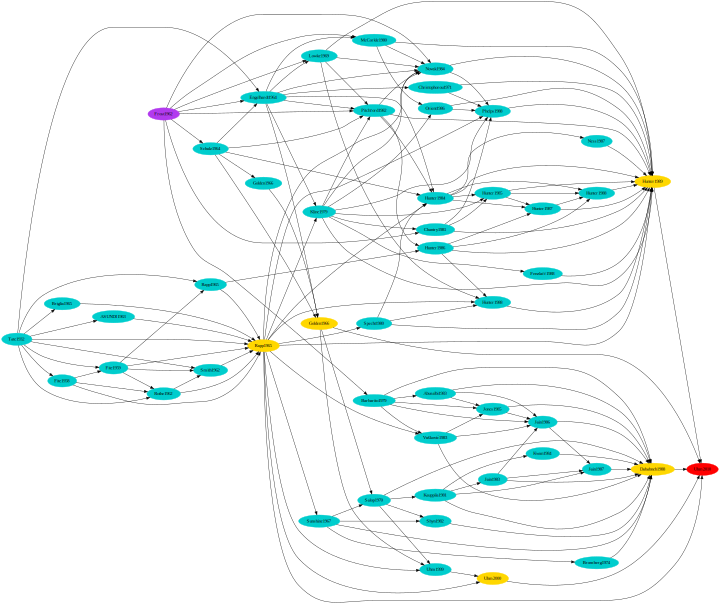

In [49]:
exp.built_graphviz( nodes, links, getlabel, getcolor )

In [40]:
for doi, citedby_count in gr.most_cited()[:10]:
    print( getlabel(doi), citedby_count, store.get(doi)['URL'])

Rapp1965 12 http://dx.doi.org/10.1063/1.1696957
Tate1932 9 http://dx.doi.org/10.1103/physrev.39.270
Kline1979 8 http://dx.doi.org/10.1063/1.325814
Frost1962 8 http://dx.doi.org/10.1103/physrev.127.1621ref in 0.458520 s.
Engelhardt1964 8 http://dx.doi.org/10.1103/physrev.135.a1566
Ramsauer1930 8 http://dx.doi.org/10.1002/andp.19303960107
Bleakney1930 7 http://dx.doi.org/10.1103/physrev.35.139
Tanaka1982 6 http://dx.doi.org/10.1088/0022-3700/15/18/024
Brüche1927 6 http://dx.doi.org/10.1002/andp.19273881602
Yoshizawa1979 6 http://dx.doi.org/10.1088/0022-3727/12/11/013
